## Neural Net Option Pricing on SPY Data 
We test the model on the SPY Options OPRA data 
- Check the EAD on SPY Data on `SPY_DATA.ipynb`

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm, qmc
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import yfinance
import datetime
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [2]:
import random
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

Using device: cpu


In [3]:
# reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [4]:
df_market = pd.read_csv("/Users/karandeepsonewane/Projects/Option Pricing using Neural Network/data/spy_option/processed/option_chain_with_vix.csv")
df = df_market.copy()
df = df.drop('VIX', axis=1)
df = df.rename(columns={"sigma" : "VIX"})
dte_data = df["dte"].describe()
dte_data

count    1.261616e+06
mean     1.802652e+02
std      2.348329e+02
min      1.000000e+00
25%      1.500000e+01
50%      8.000000e+01
75%      2.520000e+02
max      1.078000e+03
Name: dte, dtype: float64

#### Loading, Cleaning and Feature Engineering
- Fetaure
    - `M`= log(S/K): Log moneyness 
    - `t_ann` = time to maturity annulized 
    - `sigma` = VIX is chosen as a proxy, if VIX is not available then constant Vol = 0.20 
      - IV is avoided to avoid circularity  
- Traget 
    - `y_{c/k}`= `mid`/`Strike` (Normalized Call price by Strike price)

In [5]:
# Check required columns exist
req = ["snapshot_date", "t_ann", "M", "mid", "strike"]

# parsing date 
df["snapshot_date"] = pd.to_datetime(df["snapshot_date"], errors="coerce")
df = df[df["snapshot_date"].notna()].copy()

# Clean data
df = df[np.isfinite(df[["t_ann","M","mid","strike"]]).all(axis=1)].copy()
df = df[(df["t_ann"] > 0) & (df["strike"] > 0) & (df["mid"] >= 0)].copy()

# Create target: C/K
df["y_ck"] = (df["mid"] / df["strike"]).astype(np.float32)

##### Data Check
We enforce basic financial and numerical sanity checks prior to model training. Time-to-maturity (t_ann) is required to be strictly positive to avoid degenerate contracts. All model inputs (M, t_ann, VIX) are constrained to be finite, excluding missing or infinite values. Option strikes are restricted to positive values, and observed mid-prices are constrained to be non-negative, consistent with no-arbitrage bounds. These assertions ensure numerical stability and economic validity of the training dataset.

In [6]:
# assert 
assert (df_market["t_ann"] > 0).all()
assert np.isfinite(df_market[["M", "t_ann", "sigma"]]).all().all(), "NaNs or infs in X"
assert (df_market["strike"] > 0).all(), "Invalid strikes"
assert (df_market["mid"] >= 0).all(), "Negative prices"            
  
# target variable 
df_market["C/K"] = df_market["mid"] / df_market["strike"]
df_market["C_dollar"] = df_market["mid"]

In [7]:
def pick_sigma(df):
    if "VIX" in df.columns and np.isfinite(df["VIX"]).mean() > 0.99:
        return "VIX"
    df["sigma_proxy"] = 0.20
    return "sigma_proxy"

sigma_col = pick_sigma(df)

#### Train:Test Split: Time based split 
- sorted by dates 
- first 80% dates for training 
- last 20% for testing


In [8]:
dates = np.array(sorted(df["snapshot_date"].unique()))
if len(dates) < 5:
    raise ValueError(f"Need more unique dates for time split, got {len(dates)}")


# 80:20
split = int(0.8 * len(dates))
train_dates = set(dates[:split])
test_dates  = set(dates[split:])


# split base on time 
train_df = df[df["snapshot_date"].isin(train_dates)].copy()
test_df  = df[df["snapshot_date"].isin(test_dates)].copy()

print(f"Unique dates: {len(dates)} | Train dates: {len(train_dates)} | Test dates: {len(test_dates)}")
print(f"Train rows: {len(train_df)} | Test rows: {len(test_df)}")

Unique dates: 272 | Train dates: 217 | Test dates: 55
Train rows: 980328 | Test rows: 281288


#### Gaussian weighted loss function calcualtion for the real data 

In [9]:
# # weights implementation
# def gaussian_weights(df, lam=1, beta=0.5, M_col="M", T_col="t_ann", normalize_mean=True):
#     M = df[M_col].astype(float).to_numpy()
#     T = df[T_col].astype(float).to_numpy()
    
#     # weights
#     w = np.exp(-(M**2) / (2.0 * lam**2) - beta * T).astype(np.float32)
#     w = np.clip(w, 1e-4, None)        #  prevents zero-weight underflow
#     w = w / (np.mean(w) + 1e-8)
    
#     # Normalize weights to mean=1
#     if normalize_mean:
#         w = w / (np.mean(w) + 1e-8)
    
#     return w

def gaussian_weights(
    df,
    lam=0.4,              # wider ATM band
    beta=5.0,             # much softer time decay
    M_col="M",
    T_col="t_ann",
    normalize_mean=True,
    w_floor_itm=0.05      # << NEW
):
    M = df[M_col].to_numpy(float)
    T = df[T_col].to_numpy(float)

    w = np.exp(-(M**2)/(2*lam**2) - beta*T)

    # region-aware floor
    itM = M > 0.05
    w[itM] = np.maximum(w[itM], w_floor_itm)

    w = w.astype(np.float32)
    w /= (np.mean(w) + 1e-8)

    if normalize_mean:
        w /= (np.mean(w) + 1e-8)

    return w


#### Hyperparameters
GWMSE Model 
- Lambda and Beta 
MiX Model 
- ALPHA 

In [10]:
LAMBDA = 0.4   # lambda (log-moneyness width) 
BETA   = 5.0   # beta (time penalty rate)
ALPHA = 0.5


w_train = gaussian_weights(train_df, 
                           lam=LAMBDA, 
                           beta=BETA)
w_test  = gaussian_weights(test_df,  
                           lam=LAMBDA, 
                           beta=BETA)


# chceck tarin weights
print(f"Train weights: min={w_train.min():.4e}, max={w_train.max():.4e}, mean={w_train.mean():.4f}, median={np.median(w_train):.4f}")

Train weights: min=5.7255e-07, max=2.5315e+00, mean=1.0000, median=0.7238


#### Feature Engineering 
#### Z-Score Standardization
The scale and distribution of the inputs are heterogeous and hence required standardization for numerical stability and gradient scaling. Therefore Z-score scaling has been used with the following properties:
- compute the mu and sigma on training data, and freeze it to avoid lookahead bias 
- apply the same transformation on the test data 
$$\hat x_{test} = \frac{x_{test} - \mu_{train}}{\sigma_{train}}$$

In [11]:
FEATURES = ["t_ann", "M", sigma_col]  # X=[T, logM, sigma]

# Input features 
X_train = train_df[FEATURES].to_numpy(np.float32)
X_test  = test_df[FEATURES].to_numpy(np.float32)

# target variables 
y_train = train_df["y_ck"].to_numpy(np.float32)                          
y_test  = test_df["y_ck"].to_numpy(np.float32)

# Compute mean/std on TRAIN only
mu = X_train.mean(axis=0)                                             
sd = X_train.std(axis=0)
sd = np.where(sd < 1e-8, 1.0, sd)

# Apply to both train and test 
# the mu and sigma are calulated on the training set only to avoid lookahead bias 
X_train_z = (X_train - mu) / sd
X_test_z  = (X_test  - mu) / sd

#### DataLoader with weights 
-  batching the dataset into batches for efficient trainig 
- using dataloader for bathcing 
- shuffle=True, training will be shuffled but (only on the training dataset)

PyTorch `DataLoader` is a utility class designed to simplify the load and iteration over the datset for training. It has various contraints for the batching, suffling and processing data. 
- Batching helps to reduce the memory footprint by leveraging parallel processing
- shuffling prevents the model to overfit to noise by shuffling the dataset on the learning, provides more stable training and avoid stucking in local minima 

In our code:
we are loading the whole dataset from the disk into ram (since dataset is small), converting it into tensor (it lives on RAM), then we `__getitem__` lazy, from the ram on the index i (all labels at i), this avoid making a copy on the ram for the shuffled data on the RAM. Which is abstracted by the the DataLoader class by pytorch

In [12]:
from torch.utils.data import Dataset, DataLoader

# Data loading and batching 
class OptionDataset(Dataset):
    def __init__(self, X, y, w):
        # convert into tensor 
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.w = torch.tensor(w, dtype=torch.float32)  # Weights 
    
    # length of data    
    def __len__(self):
        return len(self.X)
    
    # get each values at index i
    def __getitem__(self, i):                                         
        return self.X[i], self.y[i], self.w[i]
    

# batch training 
BATCH = 2048

train_ds = OptionDataset(X_train_z, y_train, w_train)
test_ds  = OptionDataset(X_test_z,  y_test,  w_test)

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, drop_last=False)        
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False, drop_last=False)

#### Model Architecture 

In [13]:
# 4.5K param model same as above 
class MLP(nn.Module):
    def __init__(self, in_dim=3, hidden=(64, 64), dropout=0.0, use_softplus=True):
        super().__init__()
        layers = []
        d = in_dim
        for h in hidden:
            layers.append(nn.Linear(d, h))
            layers.append(nn.ELU())
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            d = h  # update input dimension for next layer

        self.body = nn.Sequential(*layers)
        self.out = nn.Linear(d, 1)  # d is last hidden size
        self.softplus = nn.Softplus() if use_softplus else nn.Identity()

    def forward(self, x):
        x = self.body(x)
        x = self.out(x)
        x = self.softplus(x)        # enforces non-negative output
        return x


In [14]:
m = MLP(in_dim=3, hidden=(64,64), use_softplus=True)
xb = torch.randn(2048, 3)
print(m(xb).shape)  # should be torch.Size([2048, 1])


torch.Size([2048, 1])


##### Loss function design
- we are using the same example as we used in the synthetic dataset. 

In [15]:
def loss_mse(pred, y):
    return torch.mean((pred - y) ** 2)

def loss_wmse(pred, y, w):
    # wighted mse formula see equation*
    return torch.sum(w * (pred - y) ** 2) / torch.sum(w)

# Mixture Loss:  alpha*WMSE + (1-alpha)*MSE
def loss_mix(pred, y, w, alpha=0.9):
    mse  = torch.mean((pred - y) ** 2)
    wmse = torch.sum(w * (pred - y) ** 2) / (torch.sum(w) + 1e-8)
    return alpha * wmse + (1.0 - alpha) * mse

#### Training and Testing
- Outer Split: Split the data into 80:20 (train:test)
- inner split: Split train data into 90:10 (train:val) 
- keep test data completely out of sample 
- validation use early stopping and model selection without peeking the test 
______________________________

##### Helper functions 
1. inner split 
2. mask for inner split and validation 
3. feature selection and numpy extraction

#### Temporal Data Partitioning 
`inner_split_masks`: This function creates a temporal split on the data by sorting the date and hold out the future date for the validation

In [16]:
def inner_split_masks(train_df_,
                            date_col = "snapshot_date", 
                            frac_train=0.9
                            ):
    """_summary_
    Time-based split unique dates in the date column,
    prevents look ahead bias by construction 

    Returns:
        inner_mask and val_mask for the time based split for the training dataset 
    """
    # assert missing date col
    assert date_col in train_df_.columns, "Missing Date Column"
    
    # arrange chronologically and select the dates 
    dts = np.array(sorted(train_df_[date_col].unique()))
    
    # cut select the index max of training data, which we will use later for validation, 
    # this avoid look-ahead bias in the validation set 
    cut = max(1, int(frac_train * len(dts)))
    
    # return set for past and future dts for immutable faster lookup later 
    inner_train_dates = set(dts[:cut])
    val_dates = set(dts[cut:])
    
    # convert it into inner and val mask  
    inner_mask = train_df_[date_col].isin(inner_train_dates).to_numpy()
    val_mask   = train_df_[date_col].isin(val_dates).to_numpy()

    # safe assertion 
    assert inner_mask.shape == val_mask.shape                                                 # shape check 
    assert inner_mask.sum() > 0, "No rows in inner train split"                               # greater than 0 rows
    assert val_mask.sum() > 0, "No rows in val split"                                       
    assert not np.any(inner_mask & val_mask), "Overlap between inner train and val!"          # no overlap for look ahead bias in val

    return inner_mask, val_mask

#### Data preperation and Data Integrity 
- `extract_arrays`: extracts the feature and target columns and convert them into np.float32 for later use 
- `fit_zscore`: Explicitly calls the fit_zscore(X_inner) only on the training set and hence avoid *Data leakage* from the test dataset. For numerical robustness np.where(sd < eps) ensures that the there is 1 SD instead of NaN or Zero  



In [17]:
## Data Extraction and Numpy conversion
def extract_arrays(df_, 
                   feature_cols,
                   y_col="y_ck", 
                   dtype=np.float32):
    """_summary_

    Args:
        df_: training dataFrame 
        feature_cols: t_ann, M and sigma  
        y_col: Strike normalized Call price 
        dtype: Defaults to np.float32.

    Returns:
        X, y numpy arrays 
    """

# check if column exists in df
    assert all(c in df_.columns for c in feature_cols), f"Missing features: {feature_cols}"  
    assert y_col in df_.columns, f"Missing target col: {y_col}"  

    X = df_[feature_cols].to_numpy(dtype)
    y = df_[y_col].to_numpy(dtype)
    return X, y


# apply z-score for inner traing only 
def fit_zscore(X, eps=1e-8):   
    mu = X.mean(axis=0)
    sd = X.std(axis=0)
    sd = np.where(sd < eps, 1.0, sd)     # if feature has zero variance -> sd = 0 -> default to 1   
    return mu, sd

def apply_zscore(X, mu, sd):
    return (X - mu) / sd


# inner val loader and tensors 
def make_inner_val_loaders(
    train_df_,
    feature_cols,
    w_train_all,                 # weights aligned with train_df_ rows (same order)
    date_col="snapshot_date",
    frac_train=0.9,
    batch_size=2048  
):
    
    # masks
    inner_mask, val_mask = inner_split_masks(train_df_, 
                                                   date_col=date_col, 
                                                   frac_train=frac_train)

    # arrays
    X_all, y_all = extract_arrays(train_df_, 
                                  feature_cols, 
                                  y_col="y_ck")

    # split
    X_inner, y_inner, w_inner = X_all[inner_mask], y_all[inner_mask], w_train_all[inner_mask]
    X_val,   y_val,   w_val   = X_all[val_mask],   y_all[val_mask],   w_train_all[val_mask]

    # fit scaler on inner-train only - no lookahead into val  
    mu, sd = fit_zscore(X_inner)

    # the X_val and X_inner z score values are kept seperate 
    X_inner_z = apply_zscore(X_inner, mu, sd).astype(np.float32)       
    X_val_z   = apply_zscore(X_val,   mu, sd).astype(np.float32) 

    # generator seed
    g = torch.Generator()
    g.manual_seed(SEED)
    
    # datasets/loaders
    inner_ds = OptionDataset(X_inner_z, y_inner, w_inner)
    inner_loader = DataLoader(inner_ds, 
                              batch_size=batch_size, 
                              shuffle=True, 
                              drop_last=False, 
                              generator=g)

    # val tensors
    X_val_t = torch.tensor(X_val_z, dtype=torch.float32, device=DEVICE)
    y_val_t = torch.tensor(y_val,   dtype=torch.float32, device=DEVICE)
    w_val_t = torch.tensor(w_val,   dtype=torch.float32, device=DEVICE)

    return inner_loader, (X_val_t, y_val_t, w_val_t), (mu, sd), (inner_mask, val_mask)

##### Training function for EPOCH and Loss Calcualtions
This function implements a single epoch training using opt=ADAM optimizer. During each iteration, loader from DataLoader provides the mini-batches of inputs (xb), targets (yb) and sample weights (wb). All tensor are passed to DEVICE. 

The objective is selected dynamically using the mode parameter:
1. 'mse': Mean squared error, treating all the error samples uniformly 
2. 'wmse': wighted mean square error with the ephasis on ATM-short dated options
3. 'mix': a convex combination of MSE and WMSE, controlled by a mixing coefficient alpha

Before backprop, gradients are cleared, setting graients to None. Epoch level loss is accumulated as a **sum of batch loss weighted by batch size** rather than averaging per-batch loss directly. This ensure partial batches are handled correctly and loss represent the true sample level avg loss across epochs. 

The function returns the avergae loss per observation for the epoch 

In [ ]:
import copy
import torch
import torch.nn as nn

# training one EPOCH  
def train_one_epoch(model, loader, opt, mode="mse"): 
    model.train()                                          # set model to training            
    total_loss = 0.0                                       # total loss 
    n_obs = 0                                              # total no of observation in the batch

    for xb, yb, wb in loader:                              # chuck training from loader 
        xb = xb.to(DEVICE)                                     # laoder handles the shuffling of batch data         
        yb = yb.to(DEVICE)                                        # handles partial batches 
        wb = wb.to(DEVICE)

        pred = model(xb).squeeze(-1)

        if mode == "mse":                                     
            loss = loss_mse(pred, yb)
        elif mode == "wmse":
            loss = loss_wmse(pred, yb, wb)
        elif mode == "mix":
            loss = loss_mix(pred, yb, wb, alpha=ALPHA)
        else:
            raise ValueError(f"Unknown mode: {mode}")

        opt.zero_grad(set_to_none=True)                       # Optimization 
        loss.backward()
        opt.step()

        bs = xb.shape[0]                                      # calcualte the batch size              
        total_loss += float(loss.item()) * bs                 # total loss = loss * batch size; convert tensor into -> float 
        n_obs += bs

    return total_loss / max(1, n_obs)                          # final loss = total loss / avg sample in epoch 

##### Loss Evaluation: MSE, WMSE and MIX model

In [19]:
# evaluation function for both methods 
@torch.no_grad()                                       # no grad for eval 
def eval_loss(model, 
              X_t, 
              y_t, 
              w_t, 
              mode="mse"):
    model.eval()
    pred = model(X_t).squeeze(-1)

    if mode == "mse":                                  # two models for comparision with different loss function
        return float(loss_mse(pred, y_t).item())
    elif mode == "wmse":                              
        return float(loss_wmse(pred, y_t, w_t).item())
    elif mode == "mix":
        return float(loss_mix(pred, y_t, w_t, alpha=ALPHA).item())
    else:
        raise ValueError(f"Unknown mode: {mode}")

##### Model Training and Early Stopping 
- this function uses the `model`, `inner_loader` (to load the batched data), `tain_one_epoch`, and `eval_loss`
- `model_train_ES` function loop over multiple EPOCH to train the model with early stopping, the early stopping condition is checked using the validation loss with a small tolerance to create a buffer for improvement in the model, the best model weights are then saved and loaded using the `state_dict` object (python dict), it returns model and best_val

In [20]:
# Training with early stopping 
def model_train_ES(
    model,
    inner_loader,
    val_pack,                 # (X_val_t, y_val_t, w_val_t)
    mode="mse",
    lr=1e-3,
    epochs=100,               
    patience=15,
    tol=1e-6,
    status_print=10
):

    model = model.to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=lr)   

    X_val_t, y_val_t, w_val_t = val_pack    # unpack
  
    best_val = float("inf")                 # best validation loss; initialize at inf 
    best_state = None                       # Model weights when best val was achieved
    bad = 0                                 # a counter for epochs without improvement in val 

    for ep in range(1, epochs + 1):          
        # for each epoch complete pass
        tr = train_one_epoch(model, 
                             inner_loader, 
                             opt, 
                             mode=mode)
        
        # for each epoch calculate eval loss 
        v  = eval_loss(model,                        
                       X_val_t, 
                       y_val_t, 
                       w_val_t, 
                       mode=mode)


        # Early stopping.                                        # if current loss < best_loss - tolerance\
        if v < best_val - tol:                                     # early stopping if no significant error 
            best_val = v                                            # update best val 
            best_state = copy.deepcopy(model.state_dict())          # to save the weights in the dataset
            bad = 0                                                   # for each epoch count the bad 
        else:
            bad += 1                                                # increment if no improvelement for the epoch

        if ep == 1 or ep % status_print == 0:
            print(f"[{mode.upper()}] ep {ep:3d} | train {tr:.6f} | val {best_val:.6f} | bad {bad}/{patience}")

        # if bad epoch > patience stop 
        if bad >= patience:
            break

    # restore the best model from the best epoch 
    if best_state is not None:
        model.load_state_dict(best_state)

    return model, best_val

#### Test Set Tensor Preparation 
- Standardization: Test features are standardized using the mean (mu) and standard deviation (sd) computed on the training set only.



In [21]:
# convert to tensors 
def make_test_tensors(test_df, 
                      feature_cols, 
                      mu, 
                      sd, 
                      w_test, 
                      y_col="y_ck"):
    # raw arrays
    X_test = test_df[feature_cols].to_numpy(np.float32)
    y_test = test_df[y_col].to_numpy(np.float32)

    # Standardize using taraing statistics - apply TRAIN-FIT scaler (mu, sd)
    X_test_z = ((X_test - mu) / sd).astype(np.float32)

    
    # create tensors 
    X_test_t = torch.tensor(X_test_z, 
                            dtype=torch.float32, 
                            device=DEVICE)              # to have consistent output after division we convert again to float32
    y_test_t = torch.tensor(y_test,   
                            dtype=torch.float32, 
                            device=DEVICE)
    w_test_t = torch.tensor(w_test,   
                            dtype=torch.float32, 
                            device=DEVICE)
    return X_test_t, y_test_t, w_test_t


#### Metrics and  Evaluation 
The module below provides a the metrics to compare the three models (MSE, WMSE and MIX objective function) to understand the performace on the MSE, WMSE, RMSE and MAE.

In [22]:
# Predict  
# model eval mode on MSE, WMSE, MAE, RMSE
@torch.no_grad()
def predict(model, X_t):
    model.eval()
    return model(X_t).squeeze(-1).detach().cpu().numpy()      # no gradients to numpy array 

# METRICS 
# MSE 
def mse(a, b):
    a = np.asarray(a)
    b = np.asarray(b)
    return float(np.mean((a - b) **2))

# WMSE 
def wmse(a, b, w):
    a = np.asarray(a)
    b = np.asarray(b)
    w = np.asarray(w)
    return float(np.sum(w * (a - b)**2) / np.sum(w))

# Metrics 
# rmse 
def rmse(a, b):
    a = np.asarray(a)
    b = np.asarray(b)
    return float(np.sqrt(np.mean((a - b) ** 2)))                # float gives better precision compared to np.float

# mae 
def mae(a, b):
    a = np.asarray(a)
    b = np.asarray(b)
    return float(np.mean(np.abs(a - b)))        

# eval on the following metrics 
def eval_on_test(model, X_test_t, y_test_t, w_test_t):
    yhat = predict(model, X_test_t)
    ytrue = y_test_t.detach().cpu().numpy()

    # unwighted results 
    results = {
        "mse": mse(yhat, ytrue),
        "rmse": rmse(yhat, ytrue),
        "mae": mae(yhat, ytrue),
        "yhat_mean": float(np.mean(yhat)),
        "y_mean": float(np.mean(ytrue)),
    }
    
    # weighted result addition 
    if w_test_t is not None:
        w_test = w_test_t.detach().cpu().numpy()
        results["wmse"] = wmse(yhat, ytrue, w_test)
        
    return results

### Model Experiment: MSE vs WMSE vs MIX Model 
This is a controlled experiment for comparing only the objective function on the same architecture and same dataset with same initialization. The only difference is the objective function. 

This block constitutes a clean ablation study where:
- architecture and data are held constant,
- initialization is identical across models,
- training hyperparameters and early stopping rules are identical,
- and the only treatment variable is the loss function.

In [ ]:
# inner/val loaders and scaler 
inner_loader, val_pack, (mu_in, sd_in), (inner_mask, val_mask) = make_inner_val_loaders(
                                                                        train_df,
                                                                        feature_cols=FEATURES,
                                                                        w_train_all=w_train,
                                                                        date_col="snapshot_date",
                                                                        frac_train=0.9,
                                                                        batch_size=BATCH
                                                                    )

# initialize models from identical weights - for comparision 
base = MLP(in_dim=len(FEATURES),                             # create a base state and use for MSE and G-WMSE Model and MIX Model  
           hidden=(64,64), 
           dropout=0.0).to(DEVICE)
base_state = copy.deepcopy(base.state_dict())


# MSE-MODEL
model_mse = MLP(in_dim=len(FEATURES),                 
                hidden=(64,64),                             
                dropout=0.0).to(DEVICE)
model_mse.load_state_dict(base_state)


# WMSE-MODEL
model_wmse = MLP(in_dim=len(FEATURES), 
                 hidden=(64,64), 
                 dropout=0.0).to(DEVICE)
model_wmse.load_state_dict(base_state)


# MIX-MODEL
model_mix = MLP(in_dim=len(FEATURES), 
                hidden=(64,64), 
                dropout=0.0).to(DEVICE)
model_mix.load_state_dict(base_state)


# train all three (same data, same init)
# mse loss
model_mse,  best_val_mse  = model_train_ES(model_mse,  
                                        inner_loader, 
                                        val_pack, 
                                        mode="mse",
                                        lr=1e-3, 
                                        epochs=300, 
                                        patience=15)


# wmse loss
model_wmse, best_val_wmse = model_train_ES(model_wmse, 
                                    inner_loader, 
                                    val_pack, 
                                    mode="wmse",
                                    lr=1e-3, 
                                    epochs=300, 
                                    patience=15)

# mix loss
model_mix, best_val_mix = model_train_ES(
    model_mix,
    inner_loader,
    val_pack,
    mode="mix",
    lr=1e-3,
    epochs=300,
    patience=15
)

print("Best val mse:", best_val_mse)
print("Best val wmse:", best_val_wmse)
print("Best val mix:", best_val_mix)


# test tensors using the SAME mu/sd (mu_in, sd_in)
X_test_t, y_test_t, w_test_t = make_test_tensors(test_df, FEATURES, mu_in, sd_in, w_test, y_col="y_ck")

# evaluate on test
print("TEST MSE model:",  eval_on_test(model_mse,  X_test_t, y_test_t, w_test_t))
print("TEST WMSE model:", eval_on_test(model_wmse, X_test_t, y_test_t, w_test_t))
print("TEST MIX model:", eval_on_test(model_mix, X_test_t, y_test_t, w_test_t))

[MSE] ep   1 | train 0.010912 | val 0.084984 | bad 0/15
[MSE] ep  10 | train 0.000935 | val 0.022316 | bad 0/15
[MSE] ep  20 | train 0.000894 | val 0.022316 | bad 10/15
[WMSE] ep   1 | train 0.009845 | val 0.017818 | bad 0/15
[WMSE] ep  10 | train 0.000146 | val 0.004667 | bad 0/15
[WMSE] ep  20 | train 0.000126 | val 0.003524 | bad 0/15
[WMSE] ep  30 | train 0.000121 | val 0.003515 | bad 7/15
[MIX] ep   1 | train 0.010548 | val 0.055954 | bad 0/15
[MIX] ep  10 | train 0.000547 | val 0.015126 | bad 0/15
[MIX] ep  20 | train 0.000514 | val 0.013146 | bad 7/15
Best val mse: 0.02231566235423088
Best val wmse: 0.0035145513247698545
Best val mix: 0.013146189041435719
TEST MSE model: {'mse': 0.07338245958089828, 'rmse': 0.2708919644355774, 'mae': 0.032291118055582047, 'yhat_mean': 0.3511728346347809, 'y_mean': 0.3792925179004669, 'wmse': 0.01044389232993126}
TEST WMSE model: {'mse': 0.08704964816570282, 'rmse': 0.2950417697429657, 'mae': 0.03523220121860504, 'yhat_mean': 0.3530040681362152, 

In [ ]:
# Get predictions (already have this function)
@torch.no_grad()
def predict(model, X_t):
    model.eval()
    return model(X_t).squeeze(-1).detach().cpu().numpy()

# Predict with all three models
pred_mse  = predict(model_mse,  X_test_t)      # mse 
pred_wmse = predict(model_wmse, X_test_t)       # G-Wmse 
pred_mix  = predict(model_mix,  X_test_t)        # mix

y_true = y_test_t.detach().cpu().numpy()


# test dataframe for analysis
test_df['pred_mse'] = pred_mse
test_df['pred_wmse'] = pred_wmse
test_df['error_mse'] = np.abs(pred_mse - y_true)
test_df['error_wmse'] = np.abs(pred_wmse - y_true)
test_df['sq_error_mse'] = (pred_mse - y_true) ** 2
test_df['sq_error_wmse'] = (pred_wmse - y_true) ** 2

print(f"Shapes: {test_df.shape}")

Shapes: (281288, 27)


##### Checks: Negative Option Price
Since negative option price is violation of the option pricing, we check the role of `softplus` in the output layer which allows for strict non-negative call option pricing 

In [25]:
def neg_report(name, preds):
    n_neg = int((preds < 0).sum())
    print(f"{name}: {n_neg:,} negative predictions ({100*n_neg/len(preds):.2f}%)")

neg_report("MSE model",  pred_mse)
neg_report("WMSE model", pred_wmse)
neg_report("MIX model",  pred_mix)

MSE model: 0 negative predictions (0.00%)
WMSE model: 0 negative predictions (0.00%)
MIX model: 0 negative predictions (0.00%)


In [26]:
# predictions
out = test_df.copy()

out["pred_ck_mse"]  = pred_mse
out["pred_ck_wmse"] = pred_wmse
out["pred_ck_mix"]  = pred_mix              # mix

# errors
out["err_mse"]  = out["pred_ck_mse"]  - y_true
out["err_wmse"] = out["pred_ck_wmse"] - y_true
out["err_mix"]  = out["pred_ck_mix"]  - y_true   # mix

out["abs_err_mse"]  = np.abs(out["err_mse"])
out["abs_err_wmse"] = np.abs(out["err_wmse"])
out["abs_err_mix"]  = np.abs(out["err_mix"])     # mix

out["sq_error_mse"]  = out["err_mse"]**2
out["sq_error_wmse"] = out["err_wmse"]**2
out["sq_error_mix"]  = out["err_mix"]**2         # mix

out.to_csv("preds_test.csv", index=False)
print("Saved: preds_test.csv")


Saved: preds_test.csv


In [27]:
def wmse_metric(y, yhat, w):
    y = np.asarray(y); yhat = np.asarray(yhat); w = np.asarray(w)
    return float(np.sum(w * (y - yhat)**2) / (np.sum(w) + 1e-12))

w_test_raw = gaussian_weights(test_df, lam=LAMBDA, beta=BETA, normalize_mean=False)

print("\nTest weighted MSE metric:")
print("  MSE-model :",  wmse_metric(y_true, pred_mse,  w_test_raw))
print("  WMSE-model:",  wmse_metric(y_true, pred_wmse, w_test_raw))
print("  MIX-model :",  wmse_metric(y_true, pred_mix,  w_test_raw))


Test weighted MSE metric:
  MSE-model : 0.01044389232993126
  WMSE-model: 0.012351471930742264
  MIX-model : 0.010873016901314259


We analyzes model performance across moneyness regimes, with a specific focus on the at-the-money (ATM) region, which is the most liquid and economically relevant part of the option surface.

The thresholds are chosen to:

- separate deep out-of-the-money and deep in-the-money tails,
- isolate a narrow ATM band around zero where pricing sensitivity (gamma) is highest,
- align with common practitioner heuristics rather than arbitrary percentiles.

In [44]:
def categorize_moneyness(M):
    if M < -0.5: return "Deep OTM"
    elif M < -0.05: return "OTM"
    elif M <= 0.05: return "ATM"
    elif M <= 0.5: return "ITM"
    else: return "Deep ITM"

out["moneyness_region"] = out["M"].apply(categorize_moneyness)
out["tradeable"] = (out["y_ck"] >= 0.001) & (out["y_ck"] < 1.0)

atm_mask = (out["M"].abs() < 0.05)

def atm_report(label, sq_err_col):
    rmse_val = float(np.sqrt(out.loc[atm_mask, sq_err_col].mean()))
    return rmse_val

atm_rmse_mse  = atm_report("MSE",  "sq_error_mse")
atm_rmse_wmse = atm_report("WMSE", "sq_error_wmse")
atm_rmse_mix  = atm_report("MIX",  "sq_error_mix")  

print("\nATM REGION (M +- 0.05) Result:")
print(f"Samples: {int(atm_mask.sum()):,}")
print(f"RMSE (MSE):  {atm_rmse_mse:.6f}")
print(f"RMSE (WMSE): {atm_rmse_wmse:.6f}  -  Improvement vs MSE: {100*(atm_rmse_mse-atm_rmse_wmse)/atm_rmse_mse:+.1f}%")
print(f"RMSE (MIX):  {atm_rmse_mix:.6f}   -  Improvement vs MSE: {100*(atm_rmse_mse-atm_rmse_mix)/atm_rmse_mse:+.1f}%")



ATM REGION (M +- 0.05) Result:
Samples: 70,193
RMSE (MSE):  0.007673
RMSE (WMSE): 0.002564  -  Improvement vs MSE: +66.6%
RMSE (MIX):  0.004777   -  Improvement vs MSE: +37.7%


In [29]:
def compare_by_region(df):
    rows = []
    for region in ["Deep OTM", "OTM", "ATM", "ITM", "Deep ITM"]:
        mask = (df["moneyness_region"] == region)
        n = int(mask.sum())
        if n == 0:
            continue

        rmse_mse  = float(np.sqrt(df.loc[mask, "sq_error_mse"].mean()))
        rmse_wmse = float(np.sqrt(df.loc[mask, "sq_error_wmse"].mean()))
        rmse_mix  = float(np.sqrt(df.loc[mask, "sq_error_mix"].mean()))

        rows.append({
            "Region": region,
            "n": n,
            "RMSE (MSE)":  rmse_mse,
            "RMSE (WMSE)": rmse_wmse,
            "RMSE (MIX)":  rmse_mix,
            "WMSE vs MSE %": 100.0 * (rmse_mse - rmse_wmse) / (rmse_mse + 1e-12),
            "MIX vs MSE %":  100.0 * (rmse_mse - rmse_mix)  / (rmse_mse + 1e-12),
        })

    return pd.DataFrame(rows)

print("PERFORMANCE BY REGION:")
reg_tab = compare_by_region(out)
print(reg_tab.to_string(index=False, float_format=lambda x: f"{x:.6g}"))
out.to_csv("predictions_with_analysis.csv", index=False)

PERFORMANCE BY REGION:
  Region      n  RMSE (MSE)  RMSE (WMSE)  RMSE (MIX)  WMSE vs MSE %  MIX vs MSE %
Deep OTM   7323 0.000249118  0.000255923 0.000318158       -2.73195      -27.7138
     OTM  68390  0.00296564   0.00312274  0.00199487       -5.29747       32.7339
     ATM  70193  0.00767337   0.00256411  0.00477735        66.5842       37.7412
     ITM 101152  0.00801004   0.00788688  0.00510647        1.53763       36.2491
Deep ITM  34230    0.776337     0.845648    0.793284       -8.92804      -2.18297


In [178]:
def compare_mse_by_region(df):
    rows = []
    for region in ["Deep OTM", "OTM", "ATM", "ITM", "Deep ITM"]:
        mask = (df["moneyness_region"] == region)
        n = int(mask.sum())
        if n == 0:
            continue

        y = df.loc[mask, "y_ck"].to_numpy()

        mse_mse  = mse(df.loc[mask, "pred_ck_mse"].to_numpy(),  y)
        mse_wmse = mse(df.loc[mask, "pred_ck_wmse"].to_numpy(), y)
        mse_mix  = mse(df.loc[mask, "pred_ck_mix"].to_numpy(),  y)

        rows.append({
            "Region": region,
            "n": n,
            "MSE (MSE-model)":  mse_mse,
            "MSE (WMSE-model)": mse_wmse,
            "MSE (MIX-model)":  mse_mix,
            "WMSE vs MSE %": 100.0 * (mse_mse - mse_wmse) / (mse_mse + 1e-12),
            "MIX vs MSE %":  100.0 * (mse_mse - mse_mix)  / (mse_mse + 1e-12),
        })

    return pd.DataFrame(rows)

mse_reg_tab = compare_mse_by_region(out)
print(mse_reg_tab.to_string(index=False, float_format=lambda x: f"{x:.6g}"))

  Region     n  MSE (MSE-model)  MSE (WMSE-model)  MSE (MIX-model)  WMSE vs MSE %  MIX vs MSE %
Deep OTM  7298      6.22722e-08       6.57211e-08      1.01571e-07       -5.53836      -63.1072
     OTM 62250      8.57759e-06       1.06981e-05       4.1091e-06        -24.721       52.0949
     ATM 59642      5.07015e-05       5.90725e-06      1.84795e-05         88.349       63.5524
     ITM 93189      6.60768e-05       6.58098e-05      2.74021e-05       0.404029         58.53
Deep ITM 33643         0.607587          0.721492         0.634784       -18.7471       -4.4763


In [181]:
def compare_mae_by_region(df):
    rows = []
    for region in ["Deep OTM", "OTM", "ATM", "ITM", "Deep ITM"]:
        mask = (df["moneyness_region"] == region)
        n = int(mask.sum())
        if n == 0:
            continue

        y = df.loc[mask, "y_ck"].to_numpy()

        mae_mse  = mae(df.loc[mask, "pred_ck_mse"].to_numpy(),  y)
        mae_wmse = mae(df.loc[mask, "pred_ck_wmse"].to_numpy(), y)
        mae_mix  = mae(df.loc[mask, "pred_ck_mix"].to_numpy(),  y)

        rows.append({
            "Region": region,
            "n": n,
            "MAE (MSE-model)":  mae_mse,
            "MAE (WMSE-model)": mae_wmse,
            "MAE (MIX-model)":  mae_mix,
            "WMSE vs MSE %": 100.0 * (mae_mse - mae_wmse) / (mae_mse + 1e-12),
            "MIX vs MSE %":  100.0 * (mae_mse - mae_mix)  / (mae_mse + 1e-12),
        })

    return pd.DataFrame(rows)

mae_reg_tab = compare_mae_by_region(out)
print(mae_reg_tab.to_string(index=False, float_format=lambda x: f"{x:.6g}"))

  Region     n  MAE (MSE-model)  MAE (WMSE-model)  MAE (MIX-model)  WMSE vs MSE %  MIX vs MSE %
Deep OTM  7298      0.000172356        0.00018561      0.000221565       -7.68992      -28.5513
     OTM 62250         0.002115        0.00175056       0.00136783        17.2313       35.3272
     ATM 59642       0.00620547        0.00187335       0.00350259        69.8114       43.5564
     ITM 93189       0.00573153        0.00547202        0.0024451        4.52776       57.3395
Deep ITM 33643         0.231721          0.268218         0.242812       -15.7507      -4.78652


In [ ]:
def overall_metrics(y, yhat):
    y = np.asarray(y); yhat = np.asarray(yhat)
    mse  = float(np.mean((y - yhat)**2))
    rmse = float(np.sqrt(mse))
    mae  = float(np.mean(np.abs(y - yhat)))
    return {"mse": mse, "rmse": rmse, "mae": mae, "yhat_mean": float(np.mean(yhat)), "y_mean": float(np.mean(y))}

m_mse  = overall_metrics(y_true, pred_mse)
m_wmse = overall_metrics(y_true, pred_wmse)
m_mix  = overall_metrics(y_true, pred_mix)

summary = pd.DataFrame([m_mse, m_wmse, m_mix], index=["MSE-model", "WMSE-model", "MIX-model"])
summary["RMSE_impr_%_vs_MSE"] = 100.0 * (summary.loc["MSE-model","rmse"] - summary["rmse"]) / (summary.loc["MSE-model","rmse"] + 1e-12)
summary["MAE_impr_%_vs_MSE"]  = 100.0 * (summary.loc["MSE-model","mae"]  - summary["mae"])  / (summary.loc["MSE-model","mae"]  + 1e-12)

print("\nOVERALL TEST FIT:")
print(summary[["mse","rmse","mae","RMSE_impr_%_vs_MSE","MAE_impr_%_vs_MSE","yhat_mean","y_mean"]]
      .to_string(float_format=lambda x: f"{x:.6g}"))
summary.to_csv("overall_fit_3way.csv")


OVERALL TEST FIT:
                 mse     rmse       mae  RMSE_impr_%_vs_MSE  MAE_impr_%_vs_MSE  yhat_mean   y_mean
MSE-model  0.0733825 0.270892 0.0322911                   0                  0   0.351173 0.379293
WMSE-model 0.0870496 0.295042 0.0352322            -8.91492           -9.10803   0.353004 0.379293
MIX-model  0.0765956 0.276759 0.0315385            -2.16587            2.33078   0.353886 0.379293


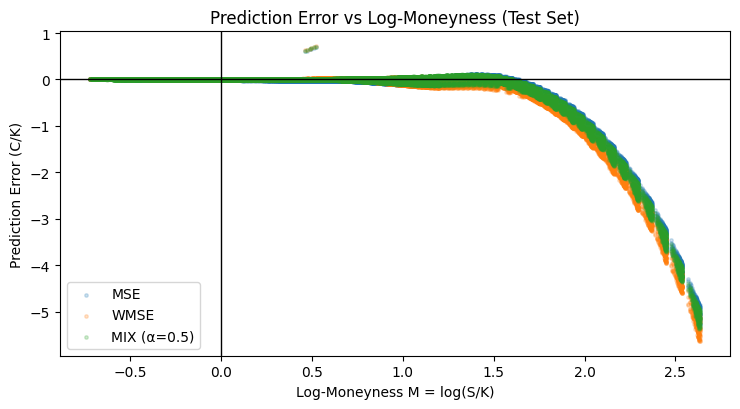

In [31]:
plt.figure(figsize=(7.5, 4.2))

plt.scatter(out["M"], out["err_mse"],  s=6, alpha=0.22, label="MSE")
plt.scatter(out["M"], out["err_wmse"], s=6, alpha=0.22, label="WMSE")
plt.scatter(out["M"], out["err_mix"],  s=6, alpha=0.22, label=f"MIX (α={ALPHA})")

plt.axhline(0, color="k", lw=1)
plt.axvline(0, color="k", lw=1)

plt.xlabel("Log-Moneyness M = log(S/K)")
plt.ylabel("Prediction Error (C/K)")
plt.title("Prediction Error vs Log-Moneyness (Test Set)")
plt.legend()
plt.tight_layout()
plt.show()


### Model Robustness Check 
no-arb diagnostic is checked on the test dataset, thus out of sample check. **This only include the tradable universe** which is T > 0.05 years, ultra-short dated options are highly sensetive to marketmicrostucture noise, wide bid-ask spread and discontinious pay-off behaviour near expiry. The stratification is done based on the moneyness where liquid universe is (M <= 0.2) which includes out-of-money, at-the-money and slightly in-the-money options, the deep-in-the-money options M (Log (S/K)) > 0.2 ~ 1.22 or 22% ITM  where the intrincic value dominates. 

#### No arb constrain 
For european call option, no-arb requires the option price to satisfy the lower bound 

$$C \geq max(Se^{-qT} - K^{-rt}, 0).........(1)$$


meaning the option must be worth atleast its discounted intrinsic value, otherwise, a static arb opportunity exist. Prices are evaluated in normalized in C/K form as above.  

A lower-bound violation is recorded when the predicted normalized price falls below the theoretical bound by more than a numerical tolerance eps = 0.001, corresponding to $0.10 per $100 strike.This tolerance accounts for floating-point precision and is well within typical bid-ask spreads for SPY options. Market mid-prices are evaluated against the same no-arbitrage criterion and serve as a baseline. Due to **discretization** i.e. there can be small violation arising due to tick-size and use of mid quotes rather than executable price. Also microstructure effects (stale quotes, bid-ask spread due to liquidity), even observed market prices may exhibit occasional bound violations, providing a realistic benchmark for model performance.

-------------

### Pointwise (single-contract) No-Arb Checks 
There conditions must hold true for each options independently.
1. non-negativity $$C \geq 0$$
2. American upper bound $$C \leq Se^{qT}$$
3. European Lower Bound (Diagnosis)
    $$C \geq max(Se^{qT} - Ke^{-rT}, 0)$$
4. American Lower bound 
    $$C \geq max(S - K, 0)$$

>considering flat r = 0.035 and constant dividend rate of q = 0.015

In [173]:
eps = 0.05  # in dollar tolearance 
r = 0.035
q = 0.015 

df = out.copy()
# maturity filter 
df = df[df["t_ann"] > 1/365].copy()

# c/k to C dollar 
df["C_mkt"] = df["mid"]
df["C_mse"] = df["pred_ck_mse"] * df["strike"] 
df["C_wmse"] = df["pred_ck_wmse"] * df["strike"]
df["C_mix"] = df["pred_ck_mix"] * df["strike"]

In [174]:
# pointwise bounds for Call option:
# non-negativity -> C >= 0
# upper bound European C <= Se^{qT}
# lower bound C >= max(Se^{qT} - Ke^{-rT}, 0)
# american lower bound for immediate exc: C >= max(S - K, 0)


S = df["spot_price"].astype(float)
K = df["strike"].astype(float)
T = df["t_ann"].astype(float)

# american immediate exercise 
df["LB_am"] = (S - K).clip(lower=0.0)

# european lower bound with r and div yield q 
df["LB_eu"] = (S * np.exp(-q*T) - K * np.exp(-r*T)).clip(lower=0.0)
 
# upper bound 
df["UB_eu"] = S*np.exp(-q*T)

In [175]:
price_cols = {
    "Market": "C_mkt",
    "MSE":    "C_mse",
    "WMSE":   "C_wmse",
    "MIX":    "C_mix",
}

bounds_rows = []
for name, col in price_cols.items():
    C = df[col].astype(float)

    # create. bool mask for violations 
    # Non-negativity: C >= 0, 
    v_nn = C < (0.0 - eps)           

    # American LB: C >= LB_am
    v_lb_am = C < (df["LB_am"] - eps)

    # European LB: C >= LB_eu
    v_lb_eu = C < (df["LB_eu"] - eps)

    # Upper bound: C <= UB_eu
    v_ub = C > (df["UB_eu"] + eps)

    # for each row we calcualte the 
    bounds_rows.append({
        "Model": name,
        "N": len(df),
        "Non_Neg_Viol%": 100.0 * v_nn.mean(),
        "LB_Am_Viol(%)": 100.0 * v_lb_am.mean(),
        "LB_Eu_Viol(%)": 100.0 * v_lb_eu.mean(),
        "Upper_Bound_Viol(%)": 100.0 * v_ub.mean(),
        "eps": eps
    })

bounds_report = pd.DataFrame(bounds_rows)
bounds_report

,Model,N,Non_Neg_Viol%,LB_Am_Viol(%),LB_Eu_Viol(%),Upper_Bound_Viol(%),eps
0,Market,256022,0.0,0.569873,0.859301,0.0,0.05
1,MSE,256022,0.0,11.854059,13.309013,0.0,0.05
2,WMSE,256022,0.0,3.507902,3.306356,0.0,0.05
3,MIX,256022,0.0,6.945497,7.465374,0.0,0.05


#### Vertical Arbitrage 
check monotonicity and convexity in each option chain (`snapshot_date`,  `expiration`) over strike 
1. Monotonicity in Strike - Vertical Spread Arb i.e. Call price must be non-increasing in strike 
$$C(K_1, T) \geq C(K_2, T)$$

2. Convexity in Maturity 
For Convexity in Maturity we avoid the butterfly arb, that is the cost of middle strike must be less than or eqaul to the weighted avg of outer strikes 
$$C_2 \leq w_1*C_1 + w_2 * C_1 $$
where: 
- $w_1 = \frac{K_3 - K_2}{ K_3 - K_1}$
- $w_2 = \frac{K_2 - K_1}{ K_3 - K_1}$

or 

$$\frac{\partial^2 C}{\partial K^2} \ge 0$$


- $\text{slope}_i = \frac{C_i - C_{i-1}}{K_i - K_{i-1}}$
- $\text{slope}_i - \text{slope}_{i-1} \ge 0$ 




In [176]:
group_cols = ["snapshot_date", "expiration"]
df = df.sort_values(group_cols + ["strike"]).copy()

# precompute delta K 
df["dk"] = df.groupby(group_cols)["strike"].diff()

In [177]:
vertical_rows = []

for name, col in price_cols.items():
    
    # price for the given model 
    df[f"C_{name}"] = df[col].astype(float)
    
    # Monotonicity in C(K) must be non-increasing in K 
    # C_{i+1} - C_{i} <= eps 
    df[f"dC_{name}"] = df.groupby(group_cols)[f"C_{name}"].diff()
    df[f"monotone_vio_{name}"] = df[f"dC_{name}"] > eps 
    
    # convexity of C(K) in K (no butterfly arb) i.e. slopes are non-decreasing in strike   
    # slope_i = (C_{i} - C_{i - 1}) / (K_i - K_{i - 1}) >= - eps_slope 
    df[f"slope_{name}"] =  df[f"dC_{name}"] /  df["dk"] 
    
    # for each chain 
    df[f"dslope_{name}"] = df.groupby(group_cols)[f"slope_{name}"].diff()
    
    #  median change in k per chain TO calculate eps_slope for the chain 
    median_dK = df.groupby(group_cols)["dk"].transform("median")
    df[f"eps_slope_{name}"] = eps / median_dK
    df[f"conv_viol_{name}"] = df[f"dslope_{name}"] < (-df[f"eps_slope_{name}"])
    
    
    # average accross the chains 
    chain_mono = df.groupby(group_cols)[f"monotone_vio_{name}"].mean()
    chain_convx = df.groupby(group_cols)[f"conv_viol_{name}"].mean()
    
    vertical_rows.append({
        "Model": name, 
        "N_contracts": len(df),
        "N_groups": int(chain_mono.shape[0]),
        "StrikeMonoViol%_avgGroup": 100.0 * chain_mono.mean(),
        "StrikeConvexViol%_avgGroup": 100.0 * chain_convx.mean(),
        "eps":eps
    })
    
vertical_rep = pd.DataFrame(vertical_rows)
vertical_rep


,Model,N_contracts,N_groups,StrikeMonoViol%_avgGroup,StrikeConvexViol%_avgGroup,eps
0,Market,256022,1555,0.009795,5.976682,0.05
1,MSE,256022,1555,1.338013,2.180758,0.05
2,WMSE,256022,1555,1.454091,3.054741,0.05
3,MIX,256022,1555,1.394541,2.394437,0.05


All the model perform worst in Montonocity in strike as the are not trained across the chain in K. However, the model has smooth in Convexity as compared to the Strike in Convexity. MSE performs best because this might act as a low pass filter for the wiggle in the second order convexity. The market violations are caused by the microstrcture noise in the bids.